In [1]:
import tensorflow as tf
import numpy as np

import struct
import os

import matplotlib.pyplot as plt
import cv2
%matplotlib notebook

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


(64, 64, 3)


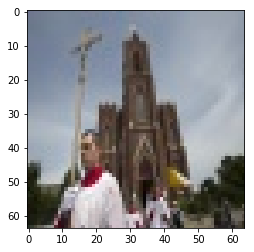

In [2]:
img = cv2.imread('./resized_images/35.jpg')
#resized_image1 = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA) 

print(np.array(img).shape)
plt.imshow(img)

plt.show()

## The image's helper class of Church Outdoor images

When an instance of this class is created, it reads in and combines all church outdoor images, being collected from LSUN image dataset, in RGB format and put them into a single data array. It further provides a class to iterate over the data in batches of a certain size.
The original images are in BGR format so that they can be read directly to RGB format using opencv library when loading the images since "imread" function reads images in reverse (if RGB, it is loaded as BGR and vice versa.). This is in order to save time when loading the data that should be already ready before loading it.
The images are converted into float images when starting training!

In [3]:
class Church_Outdoors():
    
    def __init__(self, direc):
        
        
        self._training_data = self._load(direc)
        
        
        np.random.seed(0)
        samples_n = self._training_data.shape[0]
        random_indices = np.random.choice(samples_n, 256, replace = False)
        np.random.seed()
        
        self._validation_data = self._training_data[random_indices]
        
        self._training_data = np.delete(self._training_data, random_indices, axis = 0)
        
    def _load(self, file_name):
        
        images = []
        for file in os.listdir(file_name):
            extension = os.path.splitext(file)[1]
            imagePath = os.path.join(file_name, file)
            images.append(cv2.imread(imagePath, cv2.IMREAD_UNCHANGED))
        return np.array(images)
    
    def get_training_batch(self, batch_size):
        return self._get_batch(self._training_data, batch_size)
    
    def get_validation_batch(self, batch_size):
        return self._get_batch(self._validation_data, batch_size)
    
    def _get_batch(self, data, batch_size):
        samples_n = data.shape[0]
        if batch_size <= 0:
            batch_size = samples_n
            
        random_indices = np.random.choice(data.shape[0], samples_n, replace = False)
        data = data[random_indices]
        
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off]

In [4]:
churches = Church_Outdoors("./resized_images/")


## Checking the dataset



(256, 64, 64, 3)


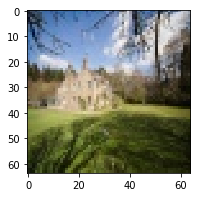

In [5]:
images = next(churches.get_training_batch(5))
print(churches._validation_data.shape)

plt.figure(figsize=(3,3))
plt.imshow(images[0])
plt.show()

# Image processing (for color spaces) helpers

Taken from https://github.com/Armour/Automatic-Image-Colorization/blob/master/image_helper.py

In [6]:

"""

Helper functions for image manipulation

"""


def rgb_to_yuv(rgb_image, scope, normalize_yuv=True):

    """

    Convert image color space from RGB to YUV

    :param rgb_image: an image with RGB color space

    :param scope: scope for this function

    :return: an image with YUV color space

    """

    with tf.name_scope(scope):

        # Get r, g, b channel

        _r = tf.slice(rgb_image, [0, 0, 0, 0], [-1, -1, -1, 1])

        _g = tf.slice(rgb_image, [0, 0, 0, 1], [-1, -1, -1, 1])

        _b = tf.slice(rgb_image, [0, 0, 0, 2], [-1, -1, -1, 1])



        # Calculate y, u, v channel

        _y = (0.299 * _r) + (0.587 * _g) + (0.114 * _b)

        _u = (-0.14713 * _r) - (0.28886 * _g) + (0.436 * _b)

        _v = (0.615 * _r) - (0.51499 * _g) - (0.10001 * _b)



        # Get image with YUV color space

        yuv_image = tf.concat([_y, _u, _v], 3)



        if normalize_yuv:

            # Normalize y, u, v channels

            yuv_image = normalized_yuv(yuv_image)



        return yuv_image





def yuv_to_rgb(yuv_image, scope, normalize_yuv=True):

    """

    Convert image color space from YUV to RGB

    :param yuv_image: an image with YUV color space

    :param scope: scope for this function

    :return: an image with RGB color space

    """

    with tf.name_scope(scope):

        if normalize_yuv:

            # Denormalize y, u, v channels

            yuv_image = denormalized_yuv(yuv_image)



        # Get y, u, v channel

        _y = tf.slice(yuv_image, [0, 0, 0, 0], [-1, -1, -1, 1])

        _u = tf.slice(yuv_image, [0, 0, 0, 1], [-1, -1, -1, 1])

        _v = tf.slice(yuv_image, [0, 0, 0, 2], [-1, -1, -1, 1])



        # Calculate r, g, b channel

        _r = (_y + 1.13983 * _v) * 255

        _g = (_y - 0.39464 * _u - 0.58060 * _v) * 255

        _b = (_y + 2.03211 * _u) * 255



        # Get image with RGB color space

        rgb_image = tf.concat([_r, _g, _b], 3)

        rgb_image = tf.maximum(rgb_image, tf.zeros(rgb_image.get_shape(), dtype=tf.float32))

        rgb_image = tf.minimum(rgb_image, tf.multiply(tf.ones(rgb_image.get_shape(), dtype=tf.float32), 255))

        rgb_image = tf.div(rgb_image, 255)



        return rgb_image




def normalized_yuv(yuv_images, y_norm_para = 0.5, u_norm_para = 0.436, v_norm_para = 0.615):

    """

    Normalize the yuv image data

    :param yuv_images: the YUV images that needs normalization

    :return: the normalized yuv image

    """

    with tf.name_scope("normalize_yuv"):

        # Split channels

        channel_y = tf.slice(yuv_images, [0, 0, 0, 0], [-1, -1, -1, 1])

        channel_u = tf.slice(yuv_images, [0, 0, 0, 1], [-1, -1, -1, 1])

        channel_v = tf.slice(yuv_images, [0, 0, 0, 2], [-1, -1, -1, 1])



        # Normalize u, v channels

        channel_u = tf.div(channel_u, u_norm_para)

        channel_v = tf.div(channel_v, v_norm_para)

        channel_u = tf.add(tf.div(channel_u, 2.0), 0.5, name="channel_u")

        channel_v = tf.add(tf.div(channel_v, 2.0), 0.5, name="channel_v")



        # Add channel data

        channel_yuv = tf.concat([channel_y, channel_u, channel_v], 3, name="channel_yuv")

        return channel_yuv





def denormalized_yuv(yuv_images, y_norm_para = 0.5, u_norm_para = 0.436, v_norm_para = 0.615):

    """

    Denormalize the yuv image data

    :param yuv_images: the YUV images that needs denormalization

    :return: the denormalized yuv image

    """

    with tf.name_scope("denormalize_yuv"):

        # Split channels

        channel_y = tf.slice(yuv_images, [0, 0, 0, 0], [-1, -1, -1, 1])

        channel_u = tf.slice(yuv_images, [0, 0, 0, 1], [-1, -1, -1, 1])

        channel_v = tf.slice(yuv_images, [0, 0, 0, 2], [-1, -1, -1, 1])



        # Denormalize u, v channels

        channel_u = tf.multiply(tf.subtract(channel_u, 0.5), 2.0)

        channel_v = tf.multiply(tf.subtract(channel_v, 0.5), 2.0)

        channel_u = tf.multiply(channel_u, u_norm_para, name="channel_u")

        channel_v = tf.multiply(channel_v, v_norm_para, name="channel_v")



        # Add channel data

        channel_yuv = tf.concat([channel_y, channel_u, channel_v], 3,name="channel_yuv")

        return channel_yuv




## Helper functions

In addition, we used the functions implemented in the solution of our course's weekly assignments since they are already simply implemented and easy to understand and use :).

Before constructing the data flow graph, we are going to define several helper functions.

`feed_forward_layer` creates a fully-connected feed-forward layer

`conv_layer` creates a convolutional layer

`back_conv_layer` creates a layer with transposed convolutions

`flatten` flattens a collection of feature maps onto an 1D-tensor

`batch_norm` creates a batch normalization layer

In [7]:
def feed_forward_layer(x, target_size, name, normalize = False, activation_function = None):
    with tf.variable_scope(name):
    
        fan_in = int(x.shape[-1])

        if activation_function == tf.nn.relu:
            var_init = tf.random_normal_initializer(stddev = 2/fan_in)
        else:
            var_init = tf.random_normal_initializer(stddev = fan_in**(-1/2))
        weights = tf.get_variable("weights", [x.shape[1], target_size], tf.float32, var_init)

        var_init = tf.constant_initializer(0.0)
        biases = tf.get_variable("biases", [target_size], tf.float32, var_init)

        activation = tf.matmul(x, weights) + biases

        if normalize:
            activation = batch_norm(activation, [0])

        return activation_function(activation) if callable(activation_function) else activation


def conv_layer(x, kernel_quantity, kernel_size, stride_size, name, normalize = False, activation_function = False):
    #print("Conv-Layer:" + str(x.shape))
    
    with tf.variable_scope(name):
        depth = x.shape[-1]
        fan_in = int(x.shape[1] * x.shape[2])

        if activation_function == tf.nn.relu or activation_function == tf.nn.leaky_relu:
            var_init = tf.random_normal_initializer(stddev = 2/fan_in)
        else:
            var_init = tf.random_normal_initializer(stddev = fan_in**(-1/2))
        kernels = tf.get_variable("kernels", [kernel_size, kernel_size, depth, kernel_quantity], tf.float32, var_init)

        var_init = tf.constant_initializer(0.0)
        biases = tf.get_variable("biases", [kernel_quantity], initializer = var_init)

        activation = tf.nn.conv2d(x, kernels, strides = [1, stride_size, stride_size, 1], padding = "SAME") + biases
        
        if normalize:
            activation = batch_norm(activation, [0, 1, 2])
        
        return activation_function(activation) if callable(activation_function) else activation


def back_conv_layer(x, target_shape, kernel_size, stride_size, normalize = False, activation_function = False):
    print("Back-Conv-Layer:" + str(x.shape))
    fan_in = int(x.shape[1] * x.shape[2])
    depth = x.shape[-1]
    
    if activation_function == tf.nn.relu or activation_function == tf.nn.leaky_relu:
        var_init = tf.random_normal_initializer(stddev = 2/fan_in)
    else:
        var_init = tf.random_normal_initializer(stddev = fan_in**(-1/2))
    kernels = tf.get_variable("kernels", [kernel_size, kernel_size, target_shape[-1], depth], tf.float32, var_init)
    
    var_init = tf.constant_initializer(0.0)
    biases = tf.get_variable("biases", [target_shape[-1]], initializer = var_init)
    
    activation = tf.nn.conv2d_transpose(x, kernels, target_shape, strides = [1, stride_size, stride_size, 1]) + biases
    
    if normalize:
        activation = batch_norm(activation, [0, 1, 2])
    
    return activation_function(activation) if callable(activation_function) else activation


def flatten(x):
    size = int(np.prod(x.shape[1:]))
    return tf.reshape(x, [-1, size])


def _pop_batch_norm(x, pop_mean, pop_var, offset, scale):
    return tf.nn.batch_normalization(x, pop_mean, pop_var, offset, scale, 1e-6)

def _batch_norm(x, pop_mean, pop_var, mean, var, offset, scale):
    decay = 0.99
    
    dependency_1 = tf.assign(pop_mean, pop_mean * decay + mean * (1 - decay))
    dependency_2 = tf.assign(pop_var, pop_var * decay + var * (1 - decay))

    with tf.control_dependencies([dependency_1, dependency_2]):
        return tf.nn.batch_normalization(x, mean, var, offset, scale, 1e-6)

def batch_norm(x, axes):
    depth = x.shape[-1]
    mean, var = tf.nn.moments(x, axes = axes)
    
    var_init = tf.constant_initializer(0.0)
    offset = tf.get_variable("offset", [depth], tf.float32, var_init)
    var_init = tf.constant_initializer(1.0)
    scale = tf.get_variable("scale", [depth], tf.float32, var_init)
    
    pop_mean = tf.get_variable("pop_mean", [depth], initializer = tf.zeros_initializer(), trainable = False)
    pop_var = tf.get_variable("pop_var", [depth], initializer = tf.ones_initializer(), trainable = False)
    
    return tf.cond(
        is_training,
        lambda: _batch_norm(x, pop_mean, pop_var, mean, var, offset, scale),
        lambda: _pop_batch_norm(x, pop_mean, pop_var, offset, scale)
    )




## Hyperparameters

The generator of the GAN is going to create fake colored images conditionally based on the black-and-white originals. The discriminator takes the generated colored ones and the original colored images as input to learn how to distinguish between real colored image and fake one. The dimension or the random input vector z is 100. The network is going to be trained for 20 epochs.
(https://arxiv.org/pdf/1702.06674.pdf) this is the paper we got inspired by. We changed the design to fit our mode, for example we used sigmoid rather than tanh as an activation fucntion in the output layer of the generator. Also we used different dataset and different yuv-rgb conversion fucntions in such a way we normalize all color values for both RGB and YUV when training.

In [8]:
batch_size = 128

image_size = 64

z_dim = 100

learning_rate = 0.01

epochs = 5

validation_step = 100

save_step = 30

## Construction Phase

Next, the computational graph of the network is created. The generator is a network with a fully-connected feed-forward to project z_vector onto the image space and 6 conv_layers with stride size of 1. It maps the random input vector _z_ (noise) onto an image of size 64x64x2 representing the U and V channels which refer to the chrominance in the YUV color space.



Then, the fakely colored images and the real colored images are concatenated and fed into the dicriminator, which is a network with 4 convolutional layers and 2 fully-connected feed-forward layers.

The final output is a single sigmoid neuron that indicates whether the image is fake or real.


In [9]:
tf.reset_default_graph()

#data
is_training = tf.placeholder(tf.bool, None)
z = tf.placeholder(tf.float32, [batch_size, z_dim], name='z')

# Color image

color_image_rgb = tf.placeholder(tf.float32, [batch_size, image_size, image_size, 3], name='real_images')

# Make pixel element value in [0, 1]
color_image_rgb_norm = tf.div(tf.cast(color_image_rgb, tf.float32), 255, name="float_image")

color_image_yuv_norm = rgb_to_yuv(color_image_rgb_norm, "rgb2yuv_for_color_image_norm")



# Gray image
gray_image = tf.image.rgb_to_grayscale(color_image_rgb_norm, name="gray_image")

gray_image_rgb = tf.image.grayscale_to_rgb(gray_image, name="gray_image_rgb")

gray_image_yuv = rgb_to_yuv(gray_image_rgb, "rgb2yuv_for_gray_image")


#get the normalized gray image in yuv format as input
gray_image_yuv_input = tf.slice(color_image_yuv_norm, [0, 0, 0, 0], [-1, -1, -1, 1], name="gray_image_y_input")

with tf.variable_scope("generator"):
        
    
    # project z
    g_h0 = feed_forward_layer(z, image_size * image_size, 'g_ffnn0')

    # reshape 
    g_h0 = tf.reshape(g_h0, [-1, image_size, image_size, 1])
    g_h0 = tf.nn.leaky_relu(batch_norm(g_h0, [0,1,2]))

    # concat with Y-channel (luminance/black_and_white chaneel)
    g_h1 = tf.concat([gray_image_yuv_input, g_h0], 3)

    #1st conv
    g_h1 = conv_layer(g_h1, 128, 7, 1, "g_conv1", True, tf.nn.relu)

    # concat with Y
    g_h2 = tf.concat([gray_image_yuv_input, g_h0, g_h1], 3)

    #2nd conv
    g_h2 = conv_layer(g_h2, 64, 5, 1, "g_conv2", True, tf.nn.relu)

    # concat with Y
    g_h3 = tf.concat([gray_image_yuv_input, g_h0, g_h2], 3)

    #3rd conv
    g_h3 = conv_layer(g_h2, 64, 5, 1, "g_conv3", True, tf.nn.relu)

    # concat with Y
    g_h4 = tf.concat([gray_image_yuv_input, g_h3], 3)

    #4th conv
    g_h4 = conv_layer(g_h4, 64, 5, 1, "g_conv4", True, tf.nn.relu)

    # concat with Y
    g_h5 = tf.concat([gray_image_yuv_input, g_h4], 3)

    #5th conv
    g_h5 = conv_layer(g_h5, 32, 5, 1, "g_conv5", True, tf.nn.relu)

    # concat with Y
    g_h6 = tf.concat([gray_image_yuv_input, g_h5], 3)

    #6th conv
    #generated color channels (U and V) except for Y (black_and_white channel)
   
    generated_images_UV = conv_layer(g_h6, 2, 5, 1, "g_conv6", True, tf.sigmoid)

# concat with Y-channel to get the completely generated yuv colored image
generated_images_yuv = tf.concat([gray_image_yuv_input, generated_images_UV], 3 ,name="predict_yuv")

#transform the generated one to rgb format
generated_images_rgb = yuv_to_rgb(generated_images_yuv, "yuv2rgb_for_pred_image")

#concat fake and real colored images to feed into the discriminator
real_and_generated_images = tf.concat([generated_images_yuv, color_image_yuv_norm], 0)

with tf.variable_scope("discriminator") as scope:

    d_h1 = conv_layer(real_and_generated_images, 64, 5, 2, "d_conv1", True, tf.nn.leaky_relu)
    
    d_h2 = conv_layer(d_h1, 128, 5, 2, "d_conv2", True, tf.nn.leaky_relu)

    d_h3 = conv_layer(d_h2, 265, 5, 2, "d_conv3", True, tf.nn.leaky_relu)

    d_h4 = conv_layer(d_h3, 512, 5, 2, "d_conv4", True, tf.nn.leaky_relu)
    
    d_h5 = feed_forward_layer(tf.reshape(d_h4, [-1, 512*4*4]), 64, name = 'd_ffnnR1')

    logits = feed_forward_layer(d_h5, 1, 'd_ffnnR2')

    
    
    


## Labels and Training

The discriminator tries to map real images on ones and fake images on zeros. The generator does only care about the discriminator's rating about the fake images. Its goal is, to create images such that the discriminator maps them onto ones and hence wrongly labels them as real. We create respective labels and calculate the respective sigmoid cross entropy.

Finally, we create two different optimizers. One optimizes the generator's and the other opeimizes the discriminator's parameters. 

In [10]:
with tf.variable_scope("target_values"):
    dis_desired = tf.concat([tf.zeros([batch_size, 1]), tf.ones([batch_size, 1])], 0)
    gen_desired = tf.ones([batch_size, 1])

with tf.variable_scope("cross_entropy"):
    dis_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = dis_desired)
    dis_cross_entropy = tf.reduce_mean(dis_cross_entropy)
    gen_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits = logits[0:batch_size], labels = gen_desired)
    gen_cross_entropy = tf.reduce_mean(gen_cross_entropy)
  
    
tf.summary.scalar("Discriminator_cross_entropy", dis_cross_entropy)
tf.summary.scalar("Generator_cross_entropy", gen_cross_entropy)

with tf.variable_scope("trainable_variables"):
    trainable_variables = tf.trainable_variables()
    dis_variables = [var for var in trainable_variables if "discriminator" in var.name]
    gen_variables = [var for var in trainable_variables if "generator" in var.name]

with tf.variable_scope("optimizer"):
    dis_optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=0.9)
    gen_optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=0.9)

    dis_training_step = dis_optimizer.minimize(dis_cross_entropy, var_list = dis_variables)
    gen_training_step = gen_optimizer.minimize(gen_cross_entropy, var_list = gen_variables)

#add summaries of fake and real colored images
tf.summary.image("color_image_rgb_norm", color_image_rgb_norm)

tf.summary.image("predict_rgb", generated_images_rgb)


summaries = tf.summary.merge_all()

## Plotting


In [11]:
#cs_fig, cs_ax = plt.subplots()


## Execution phase

In the training loop, we feed random _z_ vectors into the network in addition to the real colored images and execute a training step for the generator and a training step for the discriminator. Every ten steps, we update the summaries.

In [ ]:
train_writer = tf.summary.FileWriter("./summaries/train", tf.get_default_graph())
valid_writer = tf.summary.FileWriter("./summaries/valid")


cs_dis = []
cs_gen = []

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    step = 0
    for epoch in range(epochs):
        for images in churches.get_training_batch(batch_size):
            
            zs = np.random.uniform(low=0, high=1, size=(batch_size, z_dim))
            
            _summaries_train, _, _, cs_dis_, cs_gen_= session.run(
                [summaries, dis_training_step, gen_training_step, dis_cross_entropy,
                 gen_cross_entropy],
                feed_dict = {z: zs, color_image_rgb: images, is_training: True}
            )
            
            cs_dis.append(cs_dis_)
            cs_gen.append(cs_gen_)
            
            if step % save_step == 0:
                train_writer.add_summary(_summaries_train, global_step = step)
                saver.save(session, "./weights/dcgan.chkpt", global_step = step)
                
              
                
            if step % validation_step == 0:
                
                
                images_valid = next(churches.get_validation_batch(batch_size))
                zs_valid = np.random.uniform(low=0, high=1, size=(batch_size, z_dim))

                _summaries_valid, _, _ = session.run(
                            [summaries, generated_images_rgb, color_image_rgb_norm],
                            feed_dict = {z: zs_valid, color_image_rgb: images_valid, is_training: True}
                        )
                valid_writer.add_summary(_summaries_valid, global_step = step)
                # Plotting
                #cs_ax.cla()
                #cs_ax.plot(cs_dis, label = "Discriminator")
                #cs_ax.plot(cs_gen, label = "Generator")
                #cs_ax.set_xlabel("Training Step")
                #cs_ax.set_ylabel("Cross Entropy")
                #cs_ax.legend()
                #cs_fig.canvas.draw()
                
                
            step += 1
            
            
    images_valid = next(churches.get_validation_batch(batch_size))
    zs_valid = np.random.uniform(low=0, high=1, size=(batch_size, z_dim))

    _summaries_valid, _, _ = session.run(
                [summaries, generated_images_rgb, color_image_rgb_norm],
                feed_dict = {z: zs_valid, color_image_rgb: images_valid, is_training: True}
            )
    
    train_writer.add_summary(_summaries_train, global_step = step)
    valid_writer.add_summary(_summaries_valid, global_step = step)
    saver.save(session, "./weights/dcgan.chkpt", global_step = step)

train_writer.flush()        